# Calibration of uncertainty set

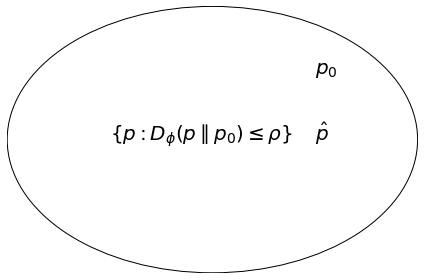

In [1]:
fig, ax = plt.subplots(1, 1)

ax.add_artist(plt.Circle((0, 0), 1, fill=False))

ax.set_ylim([-1, 1])
ax.set_xlim([-1, 1])
ax.axis('off')

plt.annotate(xy=[0.5,0.5], s='$p_0$', fontsize=20)

plt.annotate(xy=[0.5,0], s='$\hat{p}$', fontsize=20)
plt.annotate(xy=[-0.5,0], s=r'$\{p : D_\phi(p \parallel p_0) \leq \rho\}$', fontsize=20)


fig.savefig('{:}/fig-illustration-ambiguity-set-calibration'.format(DIR_FIGURES))